In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from langdetect import detect

import warnings; warnings.simplefilter('ignore')

# Categorizing Videos By Text

In [41]:
# Video Related Features
dfData = pd.read_csv('../data/All_data_cbs.csv')

#nsfw

dfNSFW = pd.read_csv('../data/all_virality_nsfw.csv')

In [42]:
dfNSFW.rename(columns={'video_id' : 'Id'}, inplace = True)

In [43]:
dfData = dfData[dfData['channelVideoCount']<2000]
dfData = dfData[dfData['subscriberCount'] >0]


In [44]:
dfData = dfData.merge(dfNSFW,on='Id',how='left')

In [74]:
dfData['nsfw_score'] = dfData['nsfw_score'].fillna(0)


In [75]:
dfData.head()

,Unnamed: 0,Unnamed: 0.1,rowHash,Id,Title,Description,LikeCount,DislikeCount,ViewCount,FavoriteCount,...,Transform,Abs Video,Chest Video,Back Video,Legs Video,Arm Video,Category,isSponsored,hasDiscount,LikeDislikeRatio
5,5,5,6,tJ3bb0V5y2Y,farmer walk 125kg each hand at papar strongest...,125kg x 2 for 40 meters,0,0,46,0,...,False,False,False,False,False,True,Arms,False,False,NaN
8,8,8,10,lT5lqT0zJgk,200kg bench press with support,Just wanna get the feel. My PR only 160 at the...,2,0,109,0,...,False,False,True,False,False,False,Chest,False,False,1.0
9,9,9,11,9qIULP6nY04,farmer walk 130kg arnold classic australia,"Arnold Classic Australia Qualifier 2016, Victo...",0,0,164,0,...,False,False,False,False,False,True,Arms,False,False,NaN
11,11,11,15,iLKDs4ISafA,30 squats for ticket,30 Squat untuk dapatkan 1 tiket.,2,0,664,0,...,False,False,False,False,True,False,Legs,False,False,1.0
14,14,14,18,1Dkt8hfpAc0,roman gavryshchuk on ukranian television show,Roman Gavryshchuk on Ukranian Television Show,8,0,3925,0,...,False,False,False,False,False,False,HowTo,False,False,1.0


# Feature Creation using Title and Description Text

## Looking at Categorical Workouts

In [76]:
# Conver to lower case 
dfData['Title'] = dfData['Title'].str.lower()


# How To
dfData['HowTo'] = (dfData['Title'].str.contains('how'))

# Motivational
dfData['Motivation'] = (dfData['Title'].str.contains('motivation'))


# Transformation
dfData['Transform'] = (dfData['Title'].str.contains('transform'))

# Abs Workout
dfData['Abs Video'] = (dfData['Title'].str.contains('abs')  | 
                       dfData['Title'].str.contains('six') | 
                       dfData['Title'].str.contains(' 6') | 
                       dfData['Title'].str.contains('abdomen'))
        
# Chest Workout
dfData['Chest Video'] = (dfData['Title'].str.contains('chest')  |
                         dfData['Title'].str.contains('pushup') | 
                         dfData['Title'].str.contains('bench') | 
                         dfData['Title'].str.contains('bench') | 
                         dfData['Title'].str.contains('push up') |
                         dfData['Title'].str.contains('dumbell press'))

# Back Workouts 
dfData['Back Video'] = (dfData['Title'].str.contains('back') | 
                        dfData['Title'].str.contains('pull up') | 
                        dfData['Title'].str.contains('chin up')  | 
                        dfData['Title'].str.contains('deadlift'))

# Leg Workouts
dfData['Legs Video'] = (dfData['Title'].str.contains('leg') | 
                        dfData['Title'].str.contains('squat') | 
                        dfData['Title'].str.contains('butt') | 
                        dfData['Title'].str.contains('quad') | 
                        dfData['Title'].str.contains('calve') )

# Arm Workout
dfData['Arm Video'] = (dfData['Title'].str.contains('shoulder') | 
                       dfData['Title'].str.contains('arm') | 
                       dfData['Title'].str.contains('bicep')  |
                       dfData['Title'].str.contains('tricep') | 
                       dfData['Title'].str.contains('delt'))



In [77]:
dfData.loc[dfData['Abs Video'] == True , 'Category'] = 'Abs'
dfData.loc[dfData['Chest Video'] == True , 'Category'] = 'Chest'
dfData.loc[dfData['Back Video'] == True, 'Category'] = 'Back'
dfData.loc[dfData['Legs Video'] == True, 'Category'] = 'Legs'
dfData.loc[dfData['Arm Video'] == True, 'Category'] = 'Arms'
dfData.loc[dfData['Motivation'] == True, 'Category'] = 'Motivation'
dfData.loc[dfData['HowTo'] == True, 'Category'] = 'HowTo'
dfData.loc[dfData['Motivation'] == True, 'Category'] = 'Motivation'
dfData.loc[dfData['Transform'] == True, 'Category'] = 'Transform'

In [78]:
#dfData = dfData.drop(['Abs Video', 'Chest Video','Back Video','Legs Video', 'Arm Video'], axis =1 )
dfData[dfData['Category'].isnull()].shape[0]

0

In [79]:
dfData = dfData[dfData['Category'].notnull()]

In [80]:
absVid = dfData[dfData['Category'] == 'Abs']
chestVid = dfData[dfData['Category'] == 'Chest']
backVid = dfData[dfData['Category'] == 'Back']
legsVid = dfData[dfData['Category'] == 'Legs']
armsVid = dfData[dfData['Category'] == 'Arms']

print "Number of Abs Related Videos: " + str(absVid.shape[0])
print "Number of Chest Related Videos: " + str(chestVid.shape[0])
print "Number of Back Related Videos: " + str(backVid.shape[0])
print "Number of Leg Related Videos: " + str(legsVid.shape[0])
print "Number of Arm Related Videos: " + str(armsVid.shape[0])

Number of Abs Related Videos: 1871
Number of Chest Related Videos: 2675
Number of Back Related Videos: 3284
Number of Leg Related Videos: 4356
Number of Arm Related Videos: 4496


## Maybe just Body Part Videos

In [81]:
#dfData = dfData[dfData['Category'].notnull()]
#dfData.shape[0]

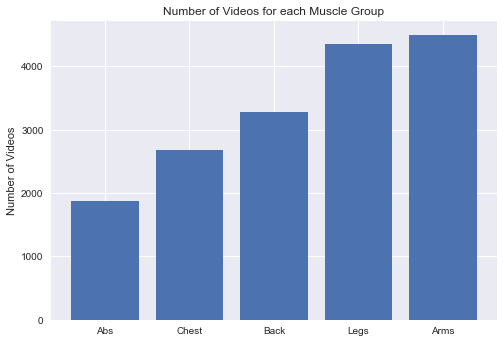

In [82]:
yCols = ['Abs', 'Chest', 'Back', 'Legs', 'Arms']
xCols = [absVid.shape[0], chestVid.shape[0], backVid.shape[0], legsVid.shape[0], armsVid.shape[0]]
y = np.arange(len(yCols))
plt.bar(y, xCols,align = 'center')
plt.xticks(y,yCols)
plt.ylabel("Number of Videos")
plt.title("Number of Videos for each Muscle Group")

## Observation
Legs/Abs/Arms being the most since they target both a guy/girl audience

## Understanding View Distribution

Category
Motivation    129344.721637
Transform      40973.867890
Chest          28579.705421
HowTo          24131.251253
Abs            20405.567076
Arms           19198.255116
Legs           16286.413453
Back           16042.858100
Name: ViewCount, dtype: float64


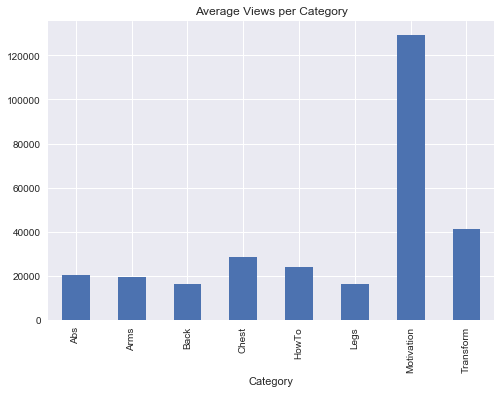

In [83]:
dfData.groupby('Category').ViewCount.mean().plot(kind="bar")
print(dfData.groupby('Category').ViewCount.mean().sort_values(ascending = False))
plt.title("Average Views per Category")
plt.show()

Category
Motivation    707.408555
Transform     396.515596
HowTo         381.314844
Abs           273.920898
Chest         262.340935
Back          237.606882
Legs          213.938017
Arms          188.471530
Name: LikeCount, dtype: float64


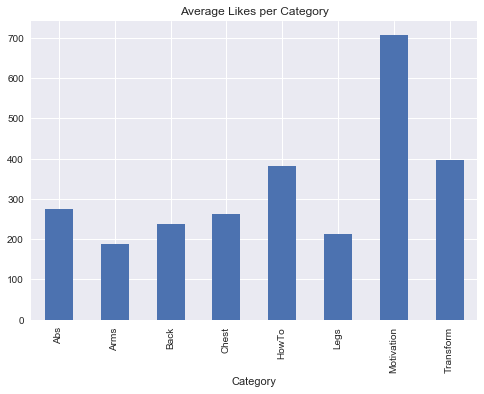

In [84]:
dfData.groupby('Category').LikeCount.mean().plot(kind="bar")
print(dfData.groupby('Category').LikeCount.mean().sort_values(ascending = False))
plt.title("Average Likes per Category")
plt.show()

Category
HowTo         66.276482
Transform     54.906422
Motivation    51.208308
Chest         36.995140
Back          30.626979
Legs          27.453168
Abs           24.502405
Arms          24.423932
Name: CommentCount, dtype: float64


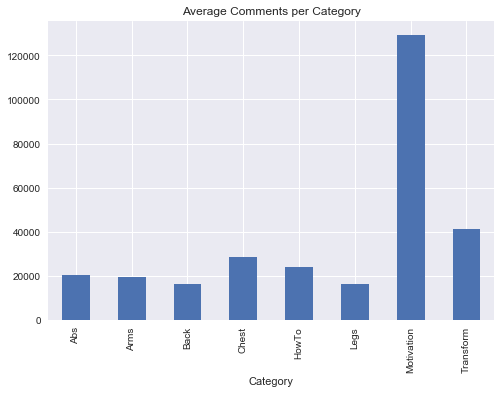

In [85]:
dfData.groupby('Category').ViewCount.mean().plot(kind="bar")
print(dfData.groupby('Category').CommentCount.mean().sort_values(ascending = False))
plt.title("Average Comments per Category")
plt.show()

## Observation

Despite Legs having more videos than chest/abs, it has the least amount of views and likes.
The most liked videos are chest and abs

### Categorizing by "Sponsored" and "Description Box" 

In [86]:
# Abs Workout
dfData['isSponsored'] = (dfData['Description'].str.contains('sponsored')  | 
                       dfData['Description'].str.contains('provided by'))

dfData['hasDiscount'] = (dfData['Description'].str.contains("discount") |
                        dfData['Description'].str.contains("code"))

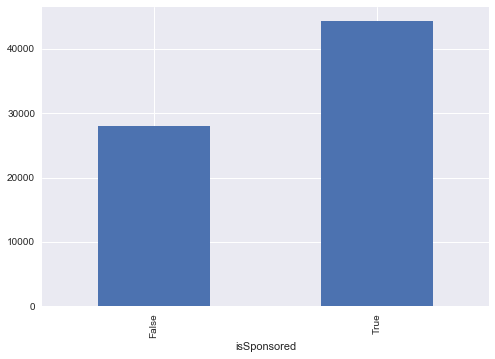

In [87]:
dfData.groupby('isSponsored').ViewCount.mean().plot(kind="bar")

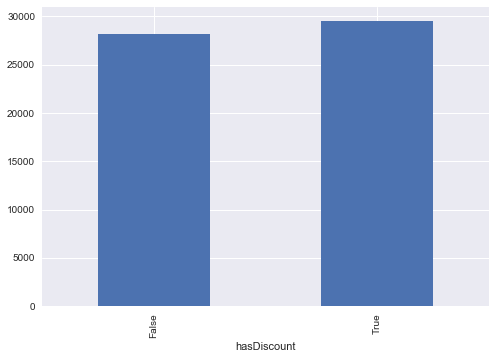

In [88]:
dfData.groupby('hasDiscount').ViewCount.mean().plot(kind="bar")

In [89]:
dfData['LikeDislikeRatio'] = dfData['LikeCount']/(dfData['LikeCount'] + dfData['DislikeCount'])

In [90]:
# Motivation
# Transformation
# Keywords: Ripped/Extreme/sexy/fat/intense
# BodyBuilding
# Tutorial/How To

In [91]:
dfData.columns

Index([u'Unnamed: 0', u'Unnamed: 0.1', u'rowHash', u'Id', u'Title',
       u'Description', u'LikeCount', u'DislikeCount', u'ViewCount',
       u'FavoriteCount', u'CommentCount', u'PublishedAt', u'Channel Id',
       u'Channel Title', u'Lang', u'publishedAt', u'subscriberCount',
       u'channelVideoCount', u'channelViewCount', u'nextHash',
       u'PrevCommentCount', u'PrevDislikeCount', u'PrevLikeCount',
       u'PrevPublishedAt', u'PrevViewCount', u'Title-clickbait', u'nsfw_score',
       u'HowTo', u'Motivation', u'Transform', u'Abs Video', u'Chest Video',
       u'Back Video', u'Legs Video', u'Arm Video', u'Category', u'isSponsored',
       u'hasDiscount', u'LikeDislikeRatio'],
      dtype='object')

In [92]:
dfData.shape

(24627, 39)

In [145]:
def feature_engineer(dfData):
    dfData =dfData.drop(['Category'],axis =1)
    dfData['is_english'] = dfData['Lang'].apply(lambda x: 1 if x=='en' else 0)
    dfData = dfData.drop('Lang', axis=1)
    
    dfData['is_Abs'] = dfData['Abs Video'].apply(lambda x: 1 if x==True else 0)
    dfData['is_Chest'] = dfData['Chest Video'].apply(lambda x: 1 if x==True else 0)
    dfData['is_Back'] = dfData['Back Video'].apply(lambda x: 1 if x==True else 0)
    dfData['is_Legs'] = dfData['Legs Video'].apply(lambda x: 1 if x==True else 0)
    dfData['is_Arms'] = dfData['Arm Video'].apply(lambda x: 1 if x==True else 0)
    dfData['isSponsored'] = dfData['isSponsored'].apply(lambda x: 1 if x==True else 0)
    dfData['Motivation'] = dfData['Motivation'].apply(lambda x: 1 if x==True else 0)
    dfData['HowTo'] = dfData['HowTo'].apply(lambda x: 1 if x==True else 0)
    dfData['PublishedYear'] = dfData['PublishedAt'].apply(lambda x: x[:4])
    dfData['ChannelAge'] =  dfData['publishedAt'].apply(lambda x: x[:4])
    dfData['channelViewCount'] = np.log1p(dfData['channelViewCount'])
    dfData = dfData.drop(['Title','Description','PublishedAt','publishedAt','Channel Id','Channel Title','Abs Video','Chest Video','Back Video',
                          'Legs Video','Arm Video','PrevPublishedAt','Id','Unnamed: 0','Unnamed: 0.1','rowHash','FavoriteCount','nextHash','hasDiscount'],axis = 1)
    
    return dfData

def drop_obvious_features(dfData):
    dfData = dfData.drop(['LikeCount','DislikeCount','CommentCount'],axis = 1)
    return dfData

def drop_engineered_features(dfData):
    dfData = dfData.drop(['nsfw_score','Title-Clickbait'],axis = 1)
    return dfData

def drop_categoricals(dfData):
    dfData = dfData.drop(['is_Abs','is_Chest','is_Back','is_Legs','is_Arms','isSponsored','is_english','HowTo'],axis =1)
    return dfData

In [146]:
df = feature_engineer(dfData).drop('LikeDislikeRatio',axis =1)

In [147]:
df.columns

Index([u'LikeCount', u'DislikeCount', u'ViewCount', u'CommentCount',
       u'subscriberCount', u'channelVideoCount', u'channelViewCount',
       u'PrevCommentCount', u'PrevDislikeCount', u'PrevLikeCount',
       u'PrevViewCount', u'Title-clickbait', u'nsfw_score', u'HowTo',
       u'Motivation', u'Transform', u'isSponsored', u'is_english', u'is_Abs',
       u'is_Chest', u'is_Back', u'is_Legs', u'is_Arms', u'PublishedYear',
       u'ChannelAge'],
      dtype='object')

In [148]:
X, y = df.drop('ViewCount',axis = 1) , np.log1p(df['ViewCount'])

In [166]:
def checkForNull(X,y):
    X = X.as_matrix().astype(float)
    print "Check For Null Values"
    for i in range(0,len(df.columns)-1):
        print df.columns[i]
        print np.any(np.isnan(X[:,i]))
    print "Check for Pred:"
    y = y.as_matrix().astype(float)
    print np.any(np.isnan(y))

In [150]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor


In [151]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25)



In [152]:
reg = GradientBoostingRegressor()
reg.fit(train_X, train_y)
reg.score(test_X, test_y)

0.90439602713758882

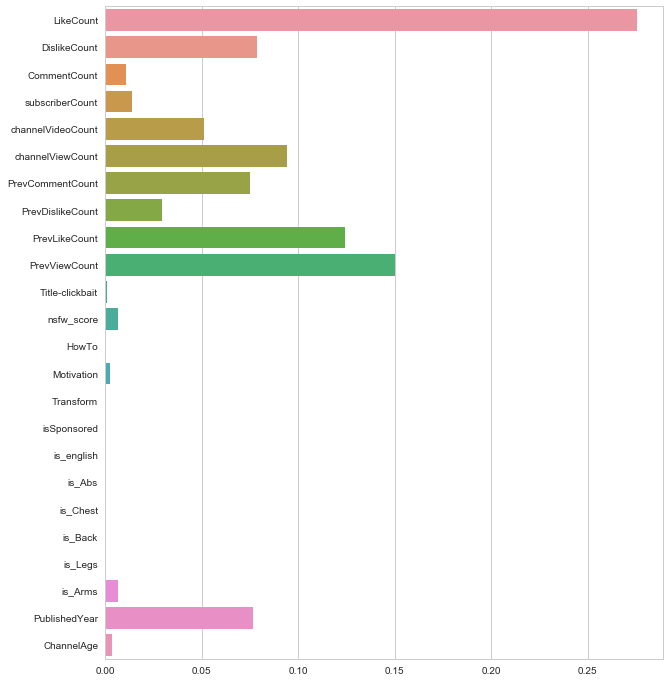

In [153]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,12))
sns.barplot(x=reg.feature_importances_, y=X.columns)

In [191]:
df = drop_categoricals(drop_obvious_features(feature_engineer(dfData))).drop('LikeDislikeRatio',axis = 1)
print df.columns
X, y = df.drop(['ViewCount'],axis=1), np.log1p(df['ViewCount'])
# checkForNull(X,y)
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25)



reg = GradientBoostingRegressor()
reg.fit(train_X, train_y)
reg.score(test_X, test_y)



Index([u'ViewCount', u'subscriberCount', u'channelVideoCount',
       u'channelViewCount', u'PrevCommentCount', u'PrevDislikeCount',
       u'PrevLikeCount', u'PrevViewCount', u'Title-clickbait', u'nsfw_score',
       u'Motivation', u'Transform', u'PublishedYear', u'ChannelAge'],
      dtype='object')


0.71291184566329613

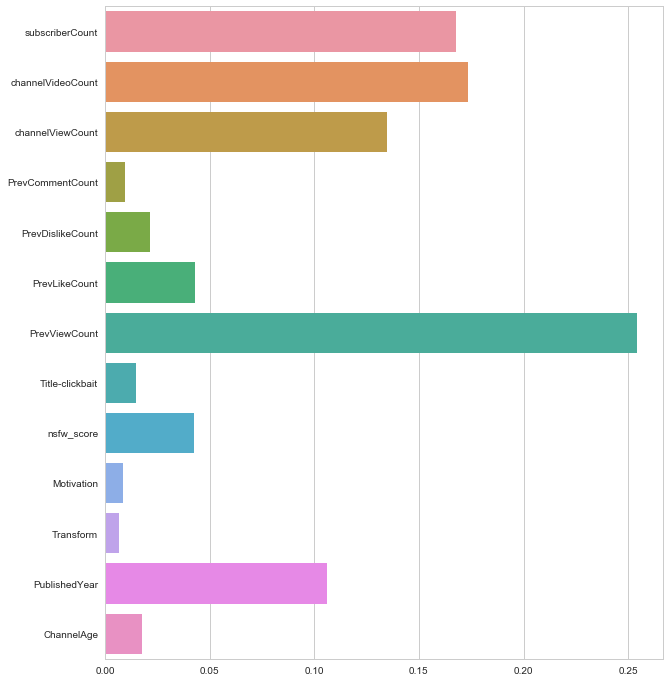

In [192]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,12))
sns.barplot(x=reg.feature_importances_, y=train_X.columns)

In [196]:
reg = XGBRegressor(n_estimators = 1000)
train_X['ChannelAge'] = train_X['ChannelAge'].astype(int)
test_X['ChannelAge'] = test_X['ChannelAge'].astype(int)
train_X['PublishedYear'] = train_X['PublishedYear'].astype(int)
test_X['PublishedYear'] = test_X['PublishedYear'].astype(int)
reg.fit(train_X, train_y)
reg.score(test_X, test_y)

import pickle
pickle.dump(reg, open("xgb001.pickle.dat", "wb"))

In [194]:
reg = XGBRegressor(n_estimators = 1000)
train_X, test_X = train_X.drop('nsfw_score',axis = 1), test_X.drop('nsfw_score',axis=1)
train_X['ChannelAge'] = train_X['ChannelAge'].astype(int)
test_X['ChannelAge'] = test_X['ChannelAge'].astype(int)
train_X['PublishedYear'] = train_X['PublishedYear'].astype(int)
test_X['PublishedYear'] = test_X['PublishedYear'].astype(int)
reg.fit(train_X, train_y)
reg.score(test_X, test_y)



0.72204481908119122

In [189]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import datasets, linear_model
reg = linear_model.LinearRegression()
train_X['ChannelAge'] = train_X['ChannelAge'].astype(int)
test_X['ChannelAge'] = test_X['ChannelAge'].astype(int)
train_X['PublishedYear'] = train_X['PublishedYear'].astype(int)
test_X['PublishedYear'] = test_X['PublishedYear'].astype(int)
reg.fit(train_X, train_y)
reg.score(test_X, test_y)

0.49744131211076426

In [133]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor()
train_X['ChannelAge'] = train_X['ChannelAge'].astype(int)
test_X['ChannelAge'] = test_X['ChannelAge'].astype(int)
train_X['PublishedYear'] = train_X['PublishedYear'].astype(int)
test_X['PublishedYear'] = test_X['PublishedYear'].astype(int)
reg.fit(train_X, train_y)
reg.score(test_X, test_y)

0.66602761241015429